In [31]:
!pip install hmmlearn

In [32]:
import numpy as np
import pandas as pd
from datetime import datetime
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/seattle-weather.csv')


# Encoding the categorical features and adding features

Let's get familiar with some basic information of the dataset

In [33]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [34]:
#some basic information
df.groupby('weather').count()

,date,precipitation,temp_max,temp_min,wind
weather,,,,,
drizzle,53,53,53,53,53
fog,101,101,101,101,101
rain,641,641,641,641,641
snow,26,26,26,26,26
sun,640,640,640,640,640


In [35]:
#We can see that the precipitation is 0 when it is drizzle
df.loc[(df['weather']=='drizzle') & (df.precipitation != 0)]

,date,precipitation,temp_max,temp_min,wind,weather


In [36]:
#Precipication is again 0 when it is sunny
df.loc[(df.weather == 'sun') & (df.precipitation)!=0]

,date,precipitation,temp_max,temp_min,wind,weather


In [37]:
#When it is foggy, again precipitation = 0
df.loc[(df['weather'] == 'fog') & (df['precipitation'] != 0)]

,date,precipitation,temp_max,temp_min,wind,weather


In [38]:
#When we have snow, the precipitation is never 0, same when it is rainy
df.loc[df['weather'] == 'snow']

,date,precipitation,temp_max,temp_min,wind,weather
13,2012-01-14,4.1,4.4,0.6,5.3,snow
14,2012-01-15,5.3,1.1,-3.3,3.2,snow
15,2012-01-16,2.5,1.7,-2.8,5.0,snow
16,2012-01-17,8.1,3.3,0.0,5.6,snow
17,2012-01-18,19.8,0.0,-2.8,5.0,snow
18,2012-01-19,15.2,-1.1,-2.8,1.6,snow
19,2012-01-20,13.5,7.2,-1.1,2.3,snow
56,2012-02-26,1.3,5.0,-1.1,3.4,snow
58,2012-02-28,3.6,6.7,-0.6,4.2,snow
59,2012-02-29,0.8,5.0,1.1,7.0,snow


In [39]:
max_temp = df['temp_min'].max()
min_temp = df['temp_min'].min()
max_wind = df['wind'].max()
min_wind = df['wind'].min()
print("max of temp_min:", max_temp)
print("min of temp_min:", min_temp)
print("max of wind:", max_wind)
print("min of wind:", min_wind)

max of temp_min: 18.3
min of temp_min: -7.1
max of wind: 9.5
min of wind: 0.4


Add Season Feature

Divide win to 4 intervals

Divide precipitation into 2 categories only.

In [40]:
# Preprocess weather encoding
weather_mapping = {'sun': 0, 'rain': 1, 'snow': 2, 'drizzle': 3, 'fog': 4}
df['Encode Weather'] = df['weather'].map(weather_mapping)

# Preprocess season encoding
arr_date = df['date']
season = np.zeros(df.shape[0])
for i, date_str in enumerate(arr_date):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    month = date.month
    if month in [12, 1, 2, 3]:
        season[i] = 0  # winter
    elif month in [4, 5, 6]:
        season[i] = 1  # spring
    elif month in [7, 8]:
        season[i] = 2  # summer
    else:
        season[i] = 3  # autumn

df['Encode Season'] = season
# Encode temperature, precipitation, and wind
df['Encode Temp'] = pd.cut(df['temp_min'], bins=[-np.inf, 2.8, 10.0, 15.0, np.inf], labels=[0, 1, 2, 3]).astype(int)
df['Encode Precipitation'] = (df['precipitation'] > 0).astype(int)
df['Encode Wind'] = pd.cut(df['wind'], bins=[-np.inf, 2.5, 5.0, 7.5, np.inf], labels=[0, 1, 2, 3]).astype(int)


In [41]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather,Encode Weather,Encode Season,Encode Temp,Encode Precipitation,Encode Wind
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,3,0.0,1,0,1
1,2012-01-02,10.9,10.6,2.8,4.5,rain,1,0.0,0,1,1
2,2012-01-03,0.8,11.7,7.2,2.3,rain,1,0.0,1,1,0
3,2012-01-04,20.3,12.2,5.6,4.7,rain,1,0.0,1,1,1
4,2012-01-05,1.3,8.9,2.8,6.1,rain,1,0.0,0,1,2


# Prepare to train

In [42]:
# Split data into training and testing sets
train_size = int(df.shape[0] * 0.8)
train_data = df[:train_size]
test_data = df[train_size:].reset_index(drop=True)

# Feature extraction
def augment_features(df):
    return df[['Encode Season', 'Encode Temp', 'Encode Precipitation', 'Encode Wind', 'Encode Weather']]

def extract_features(df):
    return df[['Encode Season', 'Encode Temp', 'Encode Precipitation', 'Encode Wind', 'Encode Weather']].values

# Extract features once to avoid recalculating in every loop
train_features = extract_features(augment_features(train_data))
test_features = extract_features(augment_features(test_data))

In [43]:
# Fit HMM model
model = GaussianHMM(n_components=5, random_state=123)
model.fit(train_features)

# Predict weather using the HMM model directly
predicted_weather = model.predict(test_features)

# Calculate accuracy
def score(predicted_weather, test_data):
    return np.mean(predicted_weather == test_data['Encode Weather'])

print("Accuracy:", score(predicted_weather, test_data))


Accuracy: 0.856655290102389


In [44]:
!pip install optuna

In [45]:
import optuna
from hmmlearn.hmm import GaussianHMM

def objective(trial):
    n_components = trial.suggest_int('n_components', 2, 6)
    covariance_type = trial.suggest_categorical('covariance_type', ['diag', 'full'])
    n_iter = trial.suggest_int('n_iter', 10, 100)

    model = GaussianHMM(n_components=n_components,
                        covariance_type=covariance_type,
                        n_iter=n_iter,
                        random_state=123)
    model.fit(train_features)

    # Predict using the HMM model
    predicted_weather = model.predict(test_features)

    # Calculate accuracy
    accuracy = np.mean(predicted_weather == test_data['Encode Weather'])

    return  accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

print("Best Parameters:", study.best_params)
print("Best Accuracy:",  study.best_value)


[I 2024-09-07 14:08:31,987] A new study created in memory with name: no-name-8818f12c-7d4f-4412-ad4f-7acbec93a86c
[I 2024-09-07 14:08:32,163] Trial 0 finished with value: 0.8532423208191127 and parameters: {'n_components': 5, 'covariance_type': 'diag', 'n_iter': 73}. Best is trial 0 with value: 0.8532423208191127.
[I 2024-09-07 14:08:32,650] Trial 1 finished with value: 0.2832764505119454 and parameters: {'n_components': 5, 'covariance_type': 'full', 'n_iter': 79}. Best is trial 0 with value: 0.8532423208191127.
[I 2024-09-07 14:08:32,777] Trial 2 finished with value: 0.3720136518771331 and parameters: {'n_components': 4, 'covariance_type': 'full', 'n_iter': 52}. Best is trial 0 with value: 0.8532423208191127.
[I 2024-09-07 14:08:32,911] Trial 3 finished with value: 0.3720136518771331 and parameters: {'n_components': 4, 'covariance_type': 'full', 'n_iter': 56}. Best is trial 0 with value: 0.8532423208191127.
[I 2024-09-07 14:08:33,057] Trial 4 finished with value: 0.0 and parameters: {

Best Parameters: {'n_components': 5, 'covariance_type': 'diag', 'n_iter': 73}
Best Accuracy: 0.8532423208191127


# Training and evaluation

In [46]:
# Fit HMM model
model = GaussianHMM(n_components=5, random_state=123)
model.fit(train_features)

# Predict weather
num_previous_days = 2
sample_weather = np.arange(5)
test_size = test_data.shape[0]
predicted_weather = []

for i in tqdm(range(test_size)):
    # Fetch previous days' data
    previous_days = test_features[max(0, i-num_previous_days):i]

    likelihood_scores = []
    for weather in sample_weather:
        current_day = np.array([test_data['Encode Season'][i], test_data['Encode Temp'][i],
                                test_data['Encode Precipitation'][i], test_data['Encode Wind'][i], weather])
        sequence = np.vstack((previous_days, current_day))
        likelihood_scores.append(model.score(sequence))

    most_probable_weather = sample_weather[np.argmax(likelihood_scores)]
    predicted_weather.append(most_probable_weather)

# Calculate accuracy
def score(predicted_weather, test_data):
    count = sum(1 for i in range(test_size) if test_data['Encode Weather'][i] == predicted_weather[i])
    return float(count) / test_size

print("Accuracy:", score(predicted_weather, test_data))


100%|██████████| 293/293 [00:00<00:00, 474.79it/s]

Accuracy: 0.8703071672354948


# Hypertuning using Grid Search and evaluation

In [51]:
from sklearn.model_selection import ParameterGrid
from hmmlearn.hmm import GaussianHMM

# Define parameter grid
param_grid = {
    'n_components': [2, 3, 4, 5],
    'covariance_type': ['diag', 'full'],
    'n_iter': [10, 50, 100],
    'init_params': ['s', 'c', 't', 'a'],
    'algorithm': ['baum-welch']
}

# List of all parameter combinations
grid = ParameterGrid(param_grid)
num_previous_days = 2

best_accuracy = 0
best_params = {}

for params in grid:
    model = GaussianHMM(n_components=params['n_components'],
                        covariance_type=params['covariance_type'],
                        n_iter=params['n_iter'],
                        init_params=params['init_params'],
                        algorithm=params['algorithm'],
                        random_state=123)

    # Fit model
    model.fit(train_features)

    # Predict and calculate accuracy
    tmp_predicted_weather = []
    for i in range(test_size):
        previous_days = test_features[max(0, i-num_previous_days):i]
        likelihood_scores = []
        for weather in sample_weather:
            current_day = np.array([test_data['Encode Season'][i], test_data['Encode Temp'][i],
                                    test_data['Encode Precipitation'][i], test_data['Encode Wind'][i], weather])
            sequence = np.vstack((previous_days, current_day))
            likelihood_scores.append(model.score(sequence))

        most_probable_weather = sample_weather[np.argmax(likelihood_scores)]
        tmp_predicted_weather.append(most_probable_weather)

    accuracy = score(tmp_predicted_weather, test_data)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")


Best Parameters: {'algorithm': 'baum-welch', 'covariance_type': 'diag', 'init_params': 's', 'n_components': 4, 'n_iter': 10}
Best Accuracy: 0.8703071672354948


# Hypertuning using Random Search

In [52]:
import numpy as np
from sklearn.model_selection import ParameterSampler

# Define narrower ranges for the parameters
n_component_values = [2, 3, 4, 5, 6, 7]  # Limit the number of n_components
arr_previous_days = [1, 2, 3, 4, 5]      # Limit the number of previous days

# Number of random combinations to try
n_random_search = 25  # Limit the number of iterations (less complexity)

# Define the limited parameter space
param_grid = {
    'n_components': n_component_values,
    'num_previous_days': arr_previous_days,
    'covariance_type': ['diag', 'full'],
    'n_iter': [10, 50, 100],
    'init_params': ['s', 'c', 't', 'a'],
}

# Randomly sample from the limited parameter space
random_search = list(ParameterSampler(param_grid, n_iter=n_random_search, random_state=123))

best_accuracy = 0
best_n_components = None
best_num_previous_days = None

# Iterate through the randomly sampled hyperparameter combinations
for params in random_search:
    n = params['n_components']
    tmp_num_previous_days = params['num_previous_days']
    cov_type= params['covariance_type']
    n_iterations= params['n_iter']
    initialize_params=params['init_params']


    # Initialize and fit the HMM model with current n_components
    tmp_model = GaussianHMM(n_components=n, random_state=123)
    tmp_model.fit(train_features)

    tmp_predicted_weather = []

    # Loop through test data to predict the weather
    for i in range(test_size):
        previous_days = test_features[max(0, i-tmp_num_previous_days):i]

        likelihood_scores = []
        for weather in sample_weather:
            current_day = np.array([test_data['Encode Season'][i], test_data['Encode Temp'][i],
                                    test_data['Encode Precipitation'][i], test_data['Encode Wind'][i], weather])
            sequence = np.vstack((previous_days, current_day))
            likelihood_scores.append(tmp_model.score(sequence))

        most_probable_weather = sample_weather[np.argmax(likelihood_scores)]
        tmp_predicted_weather.append(most_probable_weather)

    # Calculate accuracy for current parameters
    accuracy = score(tmp_predicted_weather, test_data)
    print(f"(n_components: {n}, num_previous_days: {tmp_num_previous_days},cov_type: {cov_type}, n_iterations: {n_iterations}, initialize_params: {initialize_params},  accuracy: {accuracy})")

    # Check if this is the best model so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = n
        best_num_previous_days = tmp_num_previous_days
        best_cov_type = cov_type
        best_n_iterations = n_iterations
        best_initialize_params = initialize_params

# Print the best parameters and accuracy
print(f"Best n_components: {best_n_components}, Best num_previous_days: {best_num_previous_days},best_cov_type: {best_cov_type}, best_n_iterations: {best_n_iterations}, best_initialize_params: {best_initialize_params}")
print(f"Best Accuracy: {best_accuracy}")


(n_components: 7, num_previous_days: 4,cov_type: diag, n_iterations: 100, initialize_params: c,  accuracy: 0.8668941979522184)
(n_components: 2, num_previous_days: 2,cov_type: diag, n_iterations: 10, initialize_params: c,  accuracy: 0.37542662116040953)
(n_components: 6, num_previous_days: 4,cov_type: full, n_iterations: 10, initialize_params: a,  accuracy: 0.6177474402730375)
(n_components: 2, num_previous_days: 5,cov_type: full, n_iterations: 100, initialize_params: a,  accuracy: 0.37542662116040953)
(n_components: 6, num_previous_days: 4,cov_type: full, n_iterations: 100, initialize_params: c,  accuracy: 0.6177474402730375)
(n_components: 4, num_previous_days: 1,cov_type: full, n_iterations: 100, initialize_params: t,  accuracy: 0.8703071672354948)
(n_components: 4, num_previous_days: 1,cov_type: diag, n_iterations: 100, initialize_params: a,  accuracy: 0.8703071672354948)
(n_components: 6, num_previous_days: 2,cov_type: diag, n_iterations: 50, initialize_params: a,  accuracy: 0.631

In [ ]:
# #We will see how many days it is snowy when the degree is above zero
# #And how many day it is rainy when the degree is below zero
# count_rain_below_zero = 0
# count_snow_above_zero = 0
# m = df.shape[0]
# count_snow = 0
# count_rain = 0
# for i in range(m):
#     if df['weather'][i] == 'snow':
#         count_snow += 1
#     if df['weather'][i] == 'rain':
#         count_rain += 1
# for i in range(m):
#     if df['temp_min'][i] <= 0.0:
#         if df['weather'][i] == 'rain':
#             count_rain_below_zero += 1
#             print("Min temp when it rains:", df['temp_min'][i])
#     else:
#         if df['weather'][i] == 'snow':
#             print("Min temp when it snows above zero:", df['temp_min'][i])
#             count_snow_above_zero += 1

# print(count_snow_above_zero)
# print(count_rain_below_zero)
# print(count_snow)
# print(count_rain)

In [ ]:
# m = df.shape[0]
# encode_temp = np.zeros(m)
# count_very_cold = 0
# count_cold = 0
# count_cool = 0
# count_warm = 0
# for i in range(m):
#     if df['temp_min'][i] <= 2.8:
#         encode_temp[i] = 0
#         count_very_cold += 1
#     if df['temp_min'][i] > 2.8 and df['temp_min'][i] <=10.0:
#         encode_temp[i] = 1
#         count_cold += 1
#     if df['temp_min'][i] > 10 and df['temp_min'][i] <= 15:
#         encode_temp[i] = 2
#         count_cool += 1
#     if df['temp_min'][i] > 15:
#         encode_temp[i] = 3
#         count_warm += 1
# df['Encode Temp'] = encode_temp
# print(count_very_cold)
# print(count_cold)
# print(count_cool)
# print(count_warm)

In [ ]:
df['Encode Precipitation']

In [ ]:
# encode_pre = np.zeros(m)
# none_pre = 0
# pre = 0
# for i in range(m):
#     pre_value = df['precipitation'][i]
#     if pre_value == 0.0:
#         encode_pre[i] = 0
#         none_pre += 1
#     else:
#         encode_pre[i] = 1
#         pre += 1
# df['Encode Precipitation'] = encode_pre
# print(none_pre)
# print(pre)

In [ ]:
# encode_wind = np.zeros(m)
# wind_1 = 0
# wind_2 = 0
# wind_3 = 0
# wind_4 = 0
# for i in range(m):
#     wind_value = df['wind'][i]
#     if wind_value < 2.5:
#         encode_wind[i] = 0
#         wind_1 += 1
#     if wind_value >= 2.5 and wind_value < 5.0:
#         encode_wind[i] = 1
#         wind_2 += 1
#     if wind_value >= 5.0 and wind_value < 7.5:
#         encode_wind[i] = 2
#         wind_3 += 1
#     if wind_value >= 7.5:
#         encode_wind[i] = 3
#         wind_4 += 1
# df['Encode Wind'] = encode_wind
# print(wind_1)
# print(wind_2)
# print(wind_3)
# print(wind_4)

# GRU MODEL

In [53]:
print(df.columns)


Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather',
       'Encode Weather', 'Encode Season', 'Encode Temp',
       'Encode Precipitation', 'Encode Wind'],
      dtype='object')


In [54]:
from sklearn.model_selection import train_test_split

weather_mapping = {'sun': 0, 'rain': 1, 'snow': 2, 'drizzle': 3, 'fog': 4}
df['Encode Weather'] = df['weather'].map(weather_mapping)
df['Encode Season'] = pd.cut(pd.to_datetime(df['date']).dt.month, bins=[0, 3, 6, 9, 12], labels=[0, 1, 2, 3]).astype(int)
df['Encode Temp'] = pd.cut(df['temp_min'], bins=[-np.inf, 2.8, 10.0, 15.0, np.inf], labels=[0, 1, 2, 3]).astype(int)
df['Encode Precipitation'] = (df['precipitation'] > 0).astype(int)
df['Encode Wind'] = pd.cut(df['wind'], bins=[-np.inf, 2.5, 5.0, 7.5, np.inf], labels=[0, 1, 2, 3]).astype(int)

features = ['Encode Season', 'Encode Temp', 'Encode Precipitation', 'Encode Wind']
target = 'Encode Weather'

num_previous_days = 10


# Function to create sequences
def create_sequences(data, target_col, num_previous_days):
    X, y = [], []
    for i in range(num_previous_days, len(data)):
        X.append(data[i-num_previous_days:i])
        y.append(target_col.iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df[features], df[target], num_previous_days)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model for Hyperparameter tuning

In [55]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [56]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model-building function
def build_model(hp):
    model = Sequential()

    # Hyperparameter for the number of GRU units
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(GRU(units=hp_units, return_sequences=True, input_shape=(num_previous_days, len(features))))

    # Dropout layer after the GRU layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Additional GRU layer (optional) with dropout
    model.add(GRU(units=hp_units))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Hyperparameter for dense layer size
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_dense_units, activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(units=5, activation='softmax'))  # Change units and activation if necessary

    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model with the specified learning rate
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Setup KerasTuner

In [57]:
from keras_tuner import RandomSearch

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_tuning'
)

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.6701030731201172

Best val_accuracy So Far: 0.6735395193099976
Total elapsed time: 00h 02m 52s


In [58]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.4314 - loss: 1.3305 - val_accuracy: 0.5819 - val_loss: 1.0276
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5493 - loss: 1.0762 - val_accuracy: 0.6509 - val_loss: 1.0313
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5635 - loss: 1.1176 - val_accuracy: 0.6293 - val_loss: 0.9595
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5538 - loss: 1.1012 - val_accuracy: 0.6638 - val_loss: 0.9647
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5718 - loss: 1.1074 - val_accuracy: 0.6552 - val_loss: 0.9867
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6058 - loss: 1.0549 - val_accuracy: 0.5603 - val_loss: 1.0367
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5793 - loss: 1.0260 - val_accuracy: 0.6767 - val_loss: 0.9465
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6178 - loss: 0.9857 - val_accuracy: 0.6810 - v

In [59]:
# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6484 - loss: 0.8564 
Test Loss: 0.926588773727417, Test Accuracy: 0.6426116824150085


# GRU Accuracy (73%)
# HMM Accuracy (87%)

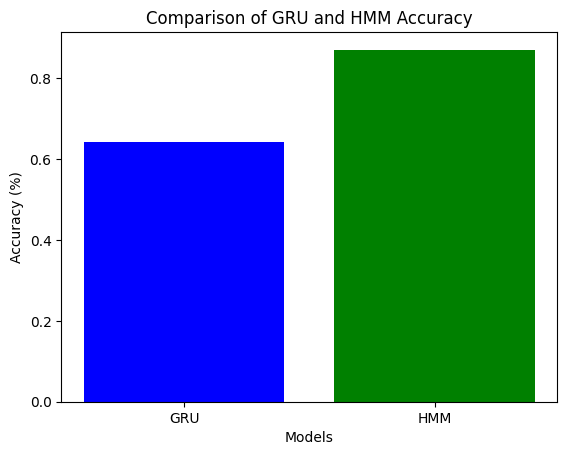

In [60]:

import matplotlib.pyplot as plt

# Data for the bar chart
models = ['GRU', 'HMM']
accuracies = [test_accuracy, best_accuracy]

# Create the bar chart
plt.bar(models, accuracies, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of GRU and HMM Accuracy')

# Display the chart
plt.show()
